In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **1.1 Load Data**

In [3]:
# Load transaction and identity datasets
transaction_data = pd.read_csv("train_transaction.csv")
identity_data = pd.read_csv("train_identity.csv")

In [4]:
# Merge datasets on 'TransactionID' (left join to keep all transactions)
data = transaction_data.merge(identity_data, on="TransactionID", how="left")

In [5]:
# Display basic info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12822 entries, 0 to 12821
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 42.5+ MB
None
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                 

In [6]:
# print number of fraudulent and non fraudulent cases
data['isFraud'].value_counts()

,count
isFraud,
0,12470
1,352


# **1.2 Handle missing values**

In [7]:
# Calculate missing value percentage
missing_percent = data.isnull().sum() * 100 / len(data)
print(missing_percent)

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
                    ...    
id_36             77.406021
id_37             77.406021
id_38             77.406021
DeviceType        77.406021
DeviceInfo        80.268289
Length: 434, dtype: float64


In [10]:
threshold = 80

# Drop columns with more than 50% missing values
columns_to_drop = missing_percent[missing_percent > threshold].index
print(columns_to_drop)

data.drop(columns=columns_to_drop, axis=1, inplace=True)

Index(['dist2', 'R_emaildomain', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14',
       'V138',
       ...
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33',
       'id_34', 'DeviceInfo'],
      dtype='object', length=189)


In [13]:
# Fill missing numerical values with median
for col in data.select_dtypes(include=["float64", "int64"]).columns:
    data.fillna({col: data[col].median()}, inplace=True)

# Fill missing categorical values with mode
for col in data.select_dtypes(include=["object"]).columns:
    data.fillna({col: data[col].mode()[0]}, inplace=True)


Why Median?

- less sensitive to outliers compared to the mean.
Many transaction-related features (e.g., TransactionAmt) have skewed distributions. The median provides a better central value without being affected by extreme fraud transactions.

# **1.3 Data Exploration**

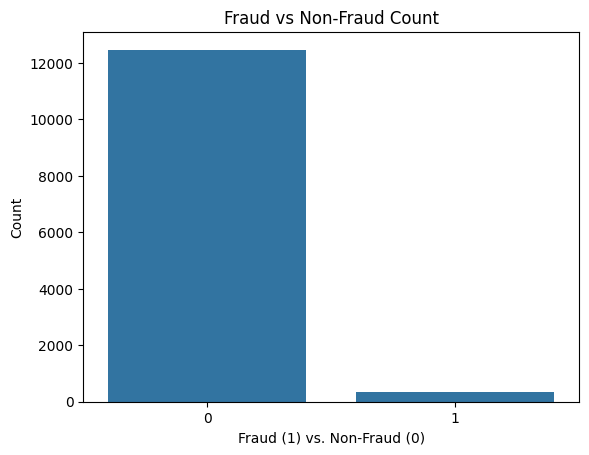

In [17]:
# Count of fraud vs. non-fraud transactions
sns.countplot(x=data["isFraud"])
plt.title("Fraud vs Non-Fraud Count")
plt.xlabel("Fraud (1) vs. Non-Fraud (0)")
plt.ylabel("Count")
plt.show()

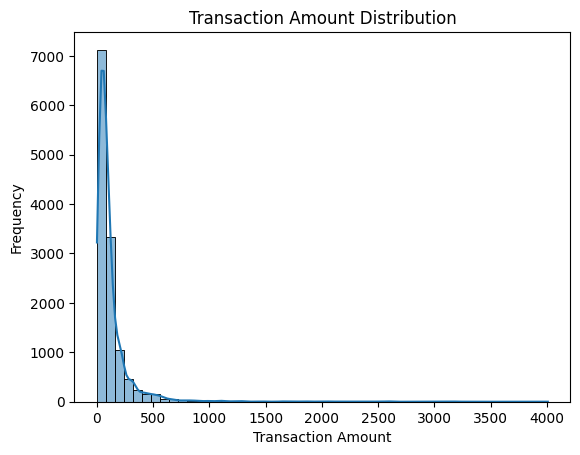

In [19]:
sns.histplot(data["TransactionAmt"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()


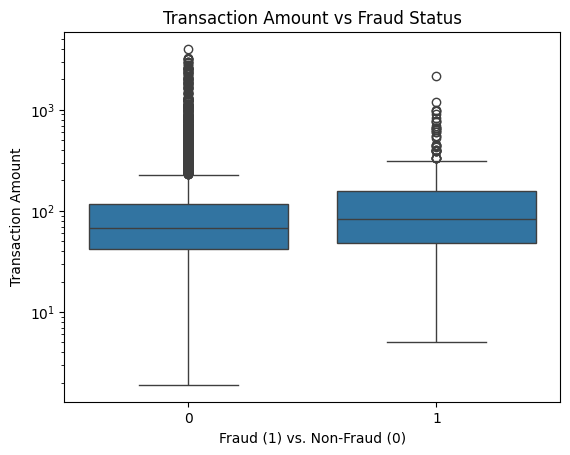

In [20]:
sns.boxplot(x=data["isFraud"], y=data["TransactionAmt"])
plt.title("Transaction Amount vs Fraud Status")
plt.xlabel("Fraud (1) vs. Non-Fraud (0)")
plt.ylabel("Transaction Amount")
plt.yscale("log")  # Log scale for better visibility of outliers
plt.show()


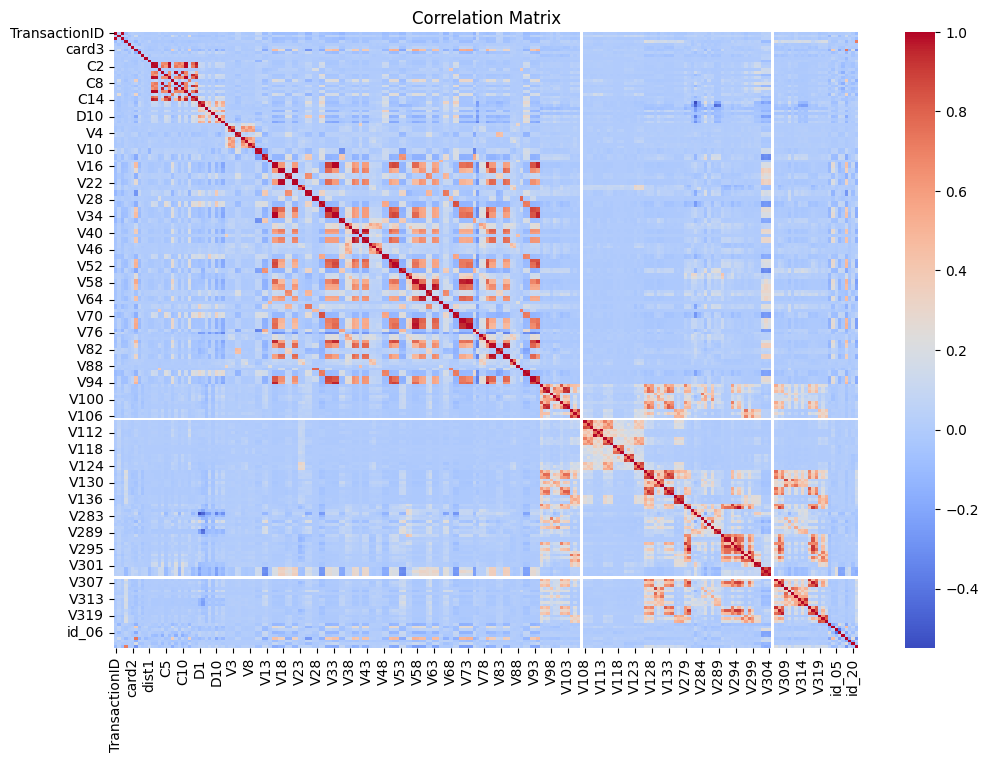

In [23]:
# Select only numeric features for correlation calculation
numeric_data = data.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


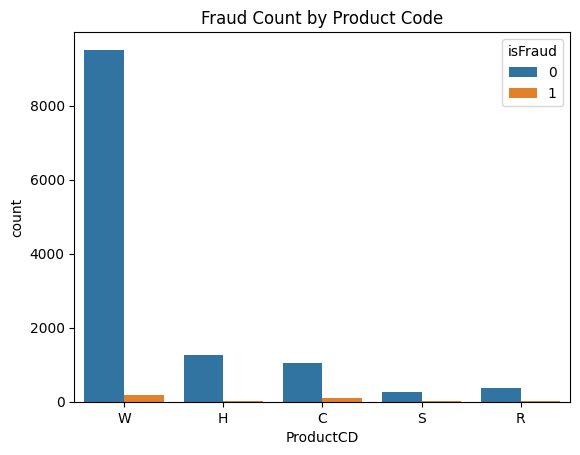

In [24]:
sns.countplot(x="ProductCD", hue="isFraud", data=data)
plt.title("Fraud Count by Product Code")
plt.show()


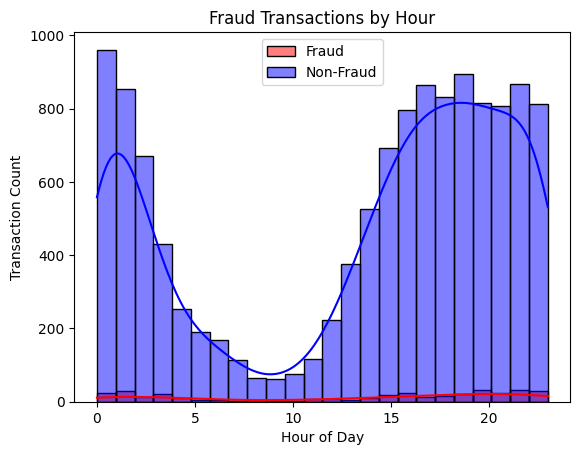

In [25]:
data["TransactionHour"] = (data["TransactionDT"] // 3600) % 24  # Extract hour

sns.histplot(data[data["isFraud"] == 1]["TransactionHour"], bins=24, kde=True, color="red", label="Fraud")
sns.histplot(data[data["isFraud"] == 0]["TransactionHour"], bins=24, kde=True, color="blue", label="Non-Fraud", alpha=0.5)
plt.title("Fraud Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.legend()
plt.show()


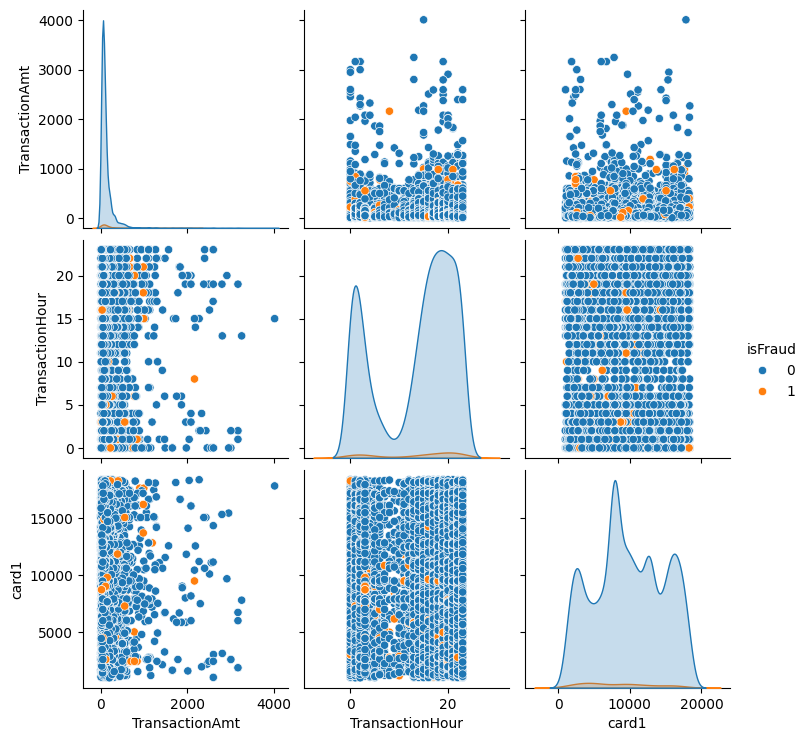

In [26]:
selected_features = ["TransactionAmt", "TransactionHour", "card1", "isFraud"]
sns.pairplot(data[selected_features], hue="isFraud", diag_kind="kde")
plt.show()


In [27]:
print(len(data.columns))

247


# **1.4 Feature Engineering**

In [ ]:
# Convert TransactionDT into hours and days
data["TransactionHour"] = (data["TransactionDT"] // 3600) % 24
data["TransactionDay"] = (data["TransactionDT"] // (3600 * 24)) % 7

# Drop the original TransactionDT column since it's not the actual timestamp
data.drop(columns=["TransactionDT"], inplace=True)
